Selectable earthquake catalogue search producing time-series plots
--

Select a date range, and use a map to select a polygon of interest. The polygon can be quite complex. The polygon and date range are used for a QuakeSearch, which provides data for time-series plots. An epicentre map is provided to show what events are included in the time-series plots.


This uses https://github.com/ellisonbg/ipyleaflet, in particular this example https://github.com/ellisonbg/ipyleaflet/blob/master/examples/DrawControl.ipynb
jupyter nbextension enable --py --sys-prefix ipyleaflet

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime
from IPython.display import HTML
import folium

In [4]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
#map needs an initial centre and zoom
center = [-38.6892,176.0930]
zoom = 10

#default depth range (km)
dep1 = 0
dep2 = 20
dp1 = str(dep1)
dp2 = str(dep2)

In [6]:
def querypoly (gj):
    """form a query polygon for WFS from GEOJSON"""
    polygon = ''
    for c in gj['geometry']['coordinates'][0]:
        lon = c[0]
        lat = c[1]
        coord = str(lon)+'+'+str(lat)+','
        polygon += coord
    polygon = polygon[:-1]
    return polygon

In [7]:
def mappoly (gj):
    """form a list of coordinate pairs for plotting on a folium map from GEOJSON"""
    polygon = []
    for c in gj['geometry']['coordinates'][0]:
        lon = c[0]
        lat = c[1]
        polygon.append((lat,lon))
    return polygon

In [8]:
#ipwidget functions
def seldate1(d1):
  global date1
  date1 = d1['new']
  date1 = date1.strftime("%Y-%m-%d")

def seldate2(d2):
  global date2
  date2 = d2['new']
  date2 = date2.strftime("%Y-%m-%d")

def deprng(d):
  global dp1, dp2
  dp1, dp2  = d['new']
  dp1 = str(dp1)
  dp2 = str(dp2)

In [9]:
def plot(p):
    global cat
    
    gj = dc.last_draw
    qpoly = querypoly(gj)
    print ('polygon is', qpoly) #this cell is the polygon, the format is suitable for a GeoNet search
    
    #get data
    url = "http://wfs.geonet.org.nz/geonet/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=geonet:quake_search_v1&outputFormat=csv&cql_filter=origintime>="+date1+"+AND+origintime<="+date2+"+AND+WITHIN(origin_geom,POLYGON((" + qpoly + "+)))+AND+depth>="+dp1+"+AND+depth<="+dp2
    cat = pd.read_csv(url, parse_dates=['origintime'], index_col='origintime')
    cat.sort_index(ascending=True, inplace=True) # sort by origintime(index), so events in time order
   
    #plot
    fig = plt.figure(figsize=(10, 10))

    d1 = datetime.datetime.strptime(date1, "%Y-%m-%d")
    d2 = datetime.datetime.strptime(date2, "%Y-%m-%d")

    # magnitude vs time
    ax1 = fig.add_subplot(3, 1, 1)
    ymax = 1.1 * cat.magnitude.max()
    ax1.set_ylim([0, ymax])
    # automatic locations
    automatic = cat.magnitude[cat['evaluationmode'] == 'automatic']
    ax1.plot(automatic, marker='o', color='red', linestyle='None', label='automatic')
    # manual locations
    manual = cat.magnitude[cat['evaluationmode'] == 'manual']
    ax1.plot(manual, marker='o', color='blue', linestyle='None', label='manual')
    plt.ylabel('magnitude')
    plt.legend(loc='best')

    # cumulative number
    ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
    ax2.plot(cat.index, cat.reset_index().index, color='red', marker='None', label='cumnum')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylabel('cumulative number', color='red')

    # cumulative energy (normalised to 1.0), on same plot
    ax2a = ax2.twinx()
    ax2a.set_ylim([0, 1])
    cat['energy'] = pow(10, (1.44 * cat['magnitude'] + 5.24))
    cat['cumeng'] = cat['energy'].cumsum()
    cat['cumeng'] = cat['cumeng'] / cat['cumeng'].max()
    ax2a.plot(cat.cumeng, color='blue', marker='None', label='cumeng')
    ax2a.tick_params(axis='y', colors='blue')
    ax2a.set_ylabel('normalised cumulative energy', color='blue')

    # depth
    ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)
    ax3.set_ylim([int(dp1), int(dp2)])
    ax3.set_xlim([d1,d2])
    # automatic locations
    automatic = cat.depth[cat['evaluationmode'] == 'automatic']
    ax3.plot(automatic, color='red', marker='o', linestyle='None', label='automatic')
    # manual locations
    manual = cat.depth[cat['evaluationmode'] == 'manual']
    ax3.plot(manual, color='blue', marker='o', linestyle='None', label='manual')
    plt.gca().invert_yaxis()
    ax3.set_ylabel('depth(km)')
    plt.legend(loc='best')

    plt.savefig('catevents.png', dpi=200)
     
    #epicentre map
    area = mappoly(gj)
    new_cent = list(tuple(map(lambda y: sum(y) / float(len(y)), zip(*area)))) #new map centre, polygon average
    emap = folium.Map(location=new_cent, width=400, height=400, zoom_start=zoom, control_scale=True)
    folium.PolyLine(area, color="blue", weight=5, opacity=0.5).add_to(emap)
    for lat, lon, mag, id in zip(cat['latitude'], cat['longitude'], cat['magnitude'], cat['publicid']):
        folium.CircleMarker(
            location=[lat, lon],
            radius=mag,
            popup=id,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(emap)
    display(emap)

In [10]:
d1 = widgets.DatePicker(description='Search start date:')
d1.observe(seldate1, names='value')

d2 = widgets.DatePicker(description='Search end date:')
d2.observe(seldate2, names='value')

d = widgets.IntRangeSlider(
    #default depth range
    value=[dep1, dep2],
    min=0,
    max=100,
    step=1,
    description='Depth range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d')
d.observe(deprng, names='value')

widgets.HBox([d1, d2, d])

HBox(children=(DatePicker(value=None, description=u'Search start date:'), DatePicker(value=None, description=u'Search end date:'), IntRangeSlider(value=(0, 20), continuous_update=False, description=u'Depth range:')))

In [11]:
m = Map(center=center, zoom=zoom, layout=dict(width='500px', height='500px'))
m

Map(center=[-38.6892, 176.093], layers=(TileLayer(attribution=u'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors', options=[u'opacity', u'attribution', u'max_zoom', u'detect_retina', u'min_zoom', u'tile_size'], url=u'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png'),), layout=Layout(height=u'500px', width=u'500px'), options=[u'keyboard_pan_offset', u'tap', u'attribution_control', u'max_zoom', u'min_zoom', u'bounce_at_zoom_limits', u'keyboard', u'scroll_wheel_zoom', u'dragging', u'inertia_max_speed', u'close_popup_on_click', u'zoom_control', u'box_zoom', u'double_click_zoom', u'tap_tolerance', u'zoom_start', u'keyboard_zoom_offset', u'inertia_deceleration', u'inertia', u'center', u'zoom', u'world_copy_jump', u'zoom_animation_threshold', u'touch_zoom'], zoom=10)

In [12]:
dc = DrawControl()

def handle_draw(self, action, geo_json):
    print(action)
    print(geo_json)

m.add_control(dc)

Run all the cells above here. Hint: click in this cell, then, from the menu, click on Cell -> Run All Above
--
1. **Using the date widgets, select the start and end dates for catalogue search, and the depth range**
2. **Use the polgyon tool to draw the search area. The tool provides instructions.**


Then, run the cell below. Hint: click in this cell, then, from the menu, click on Cell -> Run All Above
--
1. **Click on the box 'Process polygon' to process the polygon of your search area**
2. **Click on the box 'Plot' to execute a QuakeSearch using your polygon search area and the date and depth ranges you selected**


HBox(children=(Button(button_style=u'success', description=u'Search and plot', style=ButtonStyle(), tooltip=u'Click here'),))

('polygon is', '175.755157+-38.87179,175.980927+-38.646922,176.173187+-38.652284,176.141052+-38.972222,175.755157+-38.87179')


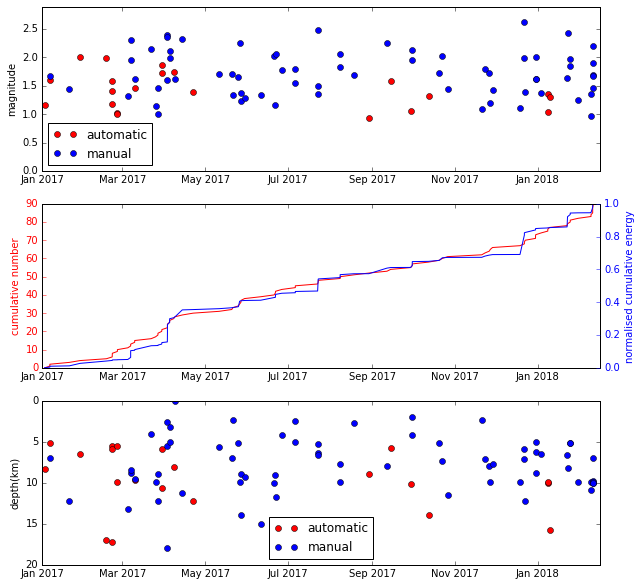

In [14]:
#search and plot
p=widgets.Button(
    description='Search and plot',
    disabled=False,
    button_style='success',
    tooltip='Click here')
p.on_click(plot)

widgets.HBox([p])